## Debugging mode

In [1]:
%matplotlib inline
#%matplotlib qt # Choose %matplotlib qt to plot to an interactive window (note it may show up behind your browser)
# Make some of the relevant imports
import cv2 # OpenCV for perspective transform
import numpy as np
import math
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc # For saving images as needed
import glob  # For reading in a list of images from a folder
import imageio
import pandas as pd
#imageio.plugins.ffmpeg.download()

In [2]:
# Enter debug data here 
debugging_folder = "Test"
image_info_path = debugging_folder + "/image_info.csv"
initial_time = 0
final_time = 10

In [3]:
# fixed data
dst = 7
scale_factor = 2
bottom_offset = 5
source = np.float32([[14, 140],
                     [300, 140],
                     [200, 95],
                     [120, 95]])

In [4]:
img_path = 'code/' + debugging_folder + '/*'
image_info_path = 'code/' + image_info_path
initial_time *= dst
final_time *=dst
img_list = glob.glob(img_path)
df = pd.read_csv(image_info_path,sep=',')
# ensure no images after rover stopped are taken and no time also
img_list = img_list[0:len(df)]
final_time = np.clip(final_time,final_time,len(img_list))

In [5]:
print(len(img_list),len(df),final_time)

4428 4428 70


## Perspective Transform

Define the perspective transform function from the lesson and test it on an image.

In [6]:
def perspect_transform(img, src, dst):
    #  image in biv with mask
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))# keep same size as input image
    # mask for obstacle to be the same as navigable terrain
    mask = cv2.warpPerspective(np.ones_like(img[:,:,0]), M, (img.shape[1], img.shape[0]))# keep same size as input image
    return warped, mask

## Color Thresholding
Define the color thresholding function from the lesson and apply it to the warped image

In [7]:
# Identify pixels above the threshold
# Threshold of RGB > 160 does a nice job of identifying ground pixels only
def color_thresh(img, min_rgb_thresh=(160, 160, 160),max_rgb_thresh=(255, 255, 255)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:, 0] < max_rgb_thresh[0]) \
                  &(img[:,:, 1] < max_rgb_thresh[1]) \
                  &(img[:,:, 2] < max_rgb_thresh[2]) \
                  &(img[:,:, 0] > min_rgb_thresh[0]) \
                  &(img[:,:, 1] > min_rgb_thresh[1]) \
                  &(img[:,:, 2] > min_rgb_thresh[2])
    
    color_select[above_thresh] = 1
    # Return the binary image
    return color_select

In [8]:
df.head()

,X_position,Y_position,yaw
0,99.6700,85.5890,202.0344
1,99.6700,85.5890,202.0344
2,99.6696,85.5887,201.9800
3,99.6688,85.5884,201.8627
4,99.6634,85.5851,202.1542


In [9]:
# plots arrow given angle, and color
def plot_arrow(dirc,color='red'):
    arrow_length = 100
    x_arrow = arrow_length * np.cos(dirc)
    y_arrow = arrow_length * np.sin(dirc)
    plt.arrow(0, 0, x_arrow, y_arrow, color=color, zorder=2, head_width=10, width=2)

In [10]:
# duplicate angle based on how close it is to origin (gives more weight to close angles than far ones)
def dulpicate(angles, dist):
    dist_max = dist.max()
    dist_min = dist.min()
    dup_angles = []    
    for i in range(len(dist)):
        dup = int((dist_max-dist[i])/(dist_max-dist_min) * 10)
        for j in range(dup):
            dup_angles.append(angles[i])
    return np.array(dup_angles)


In [11]:
def dirc_to_angle(angles,dirc,a=-15,b=15):
    max_angles = angles.max()
    min_angles = angles.min()
    steering_angle = (b-a) * (dirc-min_angles)/(max_angles-min_angles) + a
    return steering_angle

In [12]:
def gen_dirc(dist,angles,dir_num = 10):
    dup_angles = dulpicate(angles,dist).round(2)
    dir_num = np.clip(dir_num,0,100)
    dir_list = []
    quantiles = np.linspace(0.1,0.95,dir_num)
    for quantile in quantiles:
        dir_list.append(np.quantile(dup_angles,quantile))
    return dir_list

In [13]:
def calc_dir(dir_list,angles,dist,obs_angles,obs_dists):
    obs_angles = obs_angles.round(2)
    obs_dists = obs_dists.round(2)
    angles = angles.round(2)
    dist = dist.round(2)
    crash_dir_list = []
    near_obs_dist_list = []
    for dirc in dir_list:
        dirc_boundaries = calc_boundary(dirc,angles,dist,10)
        near_obs_dist = obs_dists[np.where((obs_angles>=dirc_boundaries[1])&(obs_angles<=dirc_boundaries[0]))]
        near_obs_dist_list.append(near_obs_dist)
        crash_dir_list.append(len(near_obs_dist)>0)
    all_crash = True
    for crash_dir in crash_dir_list:
        all_crash = all_crash and crash_dir
    dist_dir = []
    if (all_crash):
        #print("all dirc crash\n")
        for i,dirc in enumerate(dir_list):
            dirc = dirc.round(2)
            #min_dist_indices = np.where(obs_angles==dirc)
            #print(max_dist_indices)
            #min_dist = obs_dists[min_dist_indices].min() if len(obs_dists[min_dist_indices]) > 0 else 0
            min_dist = near_obs_dist_list[i].min()
            dist_dir.append(min_dist)  
    else:
        crash_dir_list = np.array(crash_dir_list)
        non_crash = np.where(crash_dir_list==False)
        print(non_crash)
        dir_list = np.array(dir_list)[non_crash]
        #print("dir list",dir_list)
        for dirc in dir_list:
            dirc = dirc.round(2)
            max_dist_indices = np.where(angles==dirc)
            #print(max_dist_indices)
            max_dist = dist[max_dist_indices].max() if len(dist[max_dist_indices]) > 0 else 0
            dist_dir.append(max_dist)
    #print("dir list",dir_list)
    #print("distance for each direction",dist_dir)
    sorted_dirc_list_idx = np.argsort(np.array(dist_dir))[::-1]
    sorted_dirc_list =  np.array(dir_list)[sorted_dirc_list_idx]
    return sorted_dirc_list

In [14]:
def calc_boundary(dirc,angles,dists,dst):
    distances = dists[np.where(angles==dirc)]
    distance = (distances.max()/dst) if len(distances) > 0 else 1
    shift_angle = math.atan(3/distance)
    return [dirc + shift_angle, dirc - shift_angle]

In [15]:
def to_cart_coords(angles,dists):
    x = dists * np.cos(angles)
    y = dists * np.sin(angles)
    return(x, y)

In [16]:
def avoid_known_routes(sorted_dirc_list,angles,dists,xpos,ypos,yaw,world_size,scale,worldmap):
    #best = int(len(sorted_dirc_list)/3)
    sorted_dirc_list = sorted_dirc_list[:3] if len(sorted_dirc_list) >= 3 else sorted_dirc_list[:len(sorted_dirc_list)]
    print(sorted_dirc_list)
    matching_percent_list= []
    nav_world_map = worldmap[:,:,2]
    for dirc in sorted_dirc_list:
        dirc_dists = dists[np.where(angles==dirc)]
        x,y = to_cart_coords(dirc,dirc_dists)
        x = x.round(0)
        y = y.round(0)
        x_world,y_world = pix_to_world(x, y, xpos, ypos, yaw, world_size, scale)
        matching_nav = nav_world_map[tuple([y_world,x_world])]
        matching_nav = matching_nav[matching_nav!=0]
        matching_percent = len(matching_nav)/len(x)
        #print("direction percent matching",matching_percent*100)
        matching_percent_list.append(matching_percent)
    matching_percent_list = np.array(matching_percent_list)
    return sorted_dirc_list[np.argmin(matching_percent_list)] if len(matching_percent_list) > 0 else sorted_dirc_list[0]

In [17]:
def dirc_nav_cart(dirc,angles,dists,dst):
    dirc_boundaries = calc_boundary(dirc,angles,dists,dst)
    indices = np.where((angles>=dirc_boundaries[1])&(angles<=dirc_boundaries[0]))
    nav_angles = angles[indices]
    nav_dists = dists[indices]
    return to_cart_coords(nav_angles,nav_dists)


In [41]:
ground_truth = mpimg.imread('calibration_images/map_bw.png')
ground_truth = np.dstack((ground_truth*0, ground_truth*1, ground_truth*0)).astype(np.float)
rover_world_map =  np.zeros((200, 200, 3), dtype=np.float) 
fake_world_map = np.zeros((200, 200, 3), dtype=np.float) 
rover_world_map = cv2.addWeighted(rover_world_map, 1, ground_truth, 0.5, 0)

In [46]:
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    
    x_pixel = -(ypos - binary_img.shape[0]).astype(np.float32)
    y_pixel = -(xpos - binary_img.shape[1]/2).astype(np.float32)
    
    return x_pixel, y_pixel

# Define a function to convert to radial coords in rover space
def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle) 
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles

# Define a function to apply a rotation to pixel positions
def rotate_pix(xpix, ypix, yaw):
    yaw_rad = yaw * np.pi / 180
    xpix_rotated = (xpix * np.cos(yaw_rad) - (ypix * np.sin(yaw_rad)))
    ypix_rotated = (xpix * np.sin(yaw_rad) + (ypix * np.cos(yaw_rad)))
    return xpix_rotated, ypix_rotated

# Define a function to perform a translation
def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # Apply a scaling and a translation
    xpix_translated = (xpix_rot/scale) + xpos
    ypix_translated = (ypix_rot/scale) + ypos
    # Return the result 
    return xpix_translated, ypix_translated

# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
   # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world


    return x_pix_world, y_pix_world

def perception_step(idx,img_list,df):
    # Grab another random image
    #idx = np.random.randint(0, len(img_list)-1)
    #idx = 85 for all crash
    image = mpimg.imread(img_list[idx])
    image_info = df.iloc[idx,:]
    image_info = image_info.squeeze()
    destination = np.float32([[image.shape[1] / 2 - dst, image.shape[0] - bottom_offset],
                          [image.shape[1] / 2 + dst, image.shape[0] - bottom_offset],
                          [image.shape[1] / 2 + dst, image.shape[0] - 2*dst - bottom_offset],
                          [image.shape[1] / 2 - dst, image.shape[0] - 2*dst - bottom_offset]])
    warped, mask = perspect_transform(image, source, destination)
    nav_threshed = color_thresh(warped)
    kernel = np.ones((dst,dst))
    nav_threshed = cv2.morphologyEx(nav_threshed, cv2.MORPH_CLOSE, kernel)
    obstacle = np.absolute(np.float32(nav_threshed) - 1) * mask
    obstacle = cv2.morphologyEx(obstacle, cv2.MORPH_OPEN, kernel)
    xpos = image_info['X_position']
    ypos = image_info['Y_position']
    yaw = image_info['yaw']
    world_size = 200
    scale =  scale_factor * dst
    # Calculate pixel values in rover-centric coords and distance/angle to all pixels
    xpix, ypix = rover_coords(nav_threshed)
    xpix_obs, ypix_obs = rover_coords(obstacle)
    dist, angles = to_polar_coords(xpix, ypix)
    obs_dist, obs_angles = to_polar_coords(xpix_obs, ypix_obs)

    obs_angles = obs_angles.round(2)
    obs_dist = obs_dist.round(2)
    angles = angles.round(2)
    dist = dist.round(2)
    # calculating steering angle based on obstacle and navigable angles and distance

    dirc_list = gen_dirc(dist,angles,10)
    sorted_dirc_list = calc_dir(dirc_list,angles,dist,obs_angles,obs_dist)
    best_dir = avoid_known_routes(sorted_dirc_list,angles,dist,xpos,ypos,yaw,world_size,scale,rover_world_map) if len(sorted_dirc_list) > 1 else sorted_dirc_list[0]
    x_pix_boundary,y_pix_boundary = dirc_nav_cart(best_dir,angles,dist,10)
    dirc_boundaries = calc_boundary(sorted_dirc_list[0],angles,dist,dst)
    #print("Sorted Directions",sorted_dirc_list)

    #dric = calc_dir(dist,angles)
    #mean_dir = np.mean(angles)


    x_nav_world, y_nav_world = pix_to_world(x_pix_boundary, y_pix_boundary,xpos, ypos, yaw, world_size, scale)
    x_obs_world, y_obs_world = pix_to_world(xpix_obs, ypix_obs,xpos, ypos, yaw, world_size, scale)
    
    # update world map
    #np.flip(img,0)
    rover_world_map[y_obs_world,x_obs_world, 0] += 1
    fake_world_map[y_obs_world,x_obs_world, 0] += 1
    fake_world_map[y_nav_world, x_nav_world, 2] +=  dst
    fake_nav_terrain = fake_world_map[:,:,2] > fake_world_map[:,:,0]
    rover_world_map[fake_nav_terrain,2] = 255
    real_nav_terrain = rover_world_map[:,:, 2] > 0
    rover_world_map[real_nav_terrain, 0] = 0

    rover_world_map[y_obs_world,x_obs_world, 0] += 255
    rover_world_map[y_nav_world, x_nav_world, 2] += 255
        #x_obs_world, y_obs_world = pix_to_world(xpix_obs, ypix_obs,xpos, ypos, yaw, world_size, scale)
    # Do some plotting
    fig = plt.figure(figsize=(12,12))
    plt.subplot(421)
    plt.imshow(image)
    plt.subplot(422)
    plt.imshow(warped)
    plt.subplot(423)
    plt.imshow(nav_threshed, cmap='gray')
    plt.subplot(424)
    plt.imshow(obstacle, cmap='gray')
    plt.subplot(425)
    plt.plot(xpix, ypix, '.')
    plt.ylim(-160, 200)
    plt.xlim(0, 200)
    for dirc in dirc_list:
        plot_arrow(dirc,'purple')
    plt.plot(xpix_obs, ypix_obs, '.',color="red")
    plt.subplot(426)
    plt.plot(xpix, ypix, '.')
    plt.ylim(-160, 200)
    plt.xlim(0, 200)
    for dirc in sorted_dirc_list:
        plot_arrow(dirc,'purple')
    plt.plot(xpix_obs, ypix_obs, '.',color="red")
    plt.subplot(427)
    plt.plot(xpix, ypix, '.')
    plt.plot(xpix_obs, ypix_obs, '.',color="red")
    plt.ylim(-160, 200)
    plt.xlim(0, 200)
    arrow_length = 100
    for dirc in dirc_boundaries:
        plot_arrow(dirc,'purple')
    plot_arrow(sorted_dirc_list[0],'purple')
    plt.subplot(428)
    plt.imshow(rover_world_map,cmap='gray')
    plt.plot(x_nav_world, y_nav_world, '.')
    plt.plot(x_obs_world, y_obs_world,'r', '.')

0
all dirc crash

dir list [-0.7659999966621378, -0.5299999713897705, -0.3199999928474426, -0.15000000596046448, -0.019999999552965164, 0.09000000357627869, 0.23000000417232513, 0.3799999952316284, 0.5799999833106995, 0.8500000238418579]
distance for each direction [29.0, 29.0, 29.0, 30.0, 32.7, 29.21, 24.76, 24.76, 24.76, 24.76]
[-0.02       -0.15000001  0.09      ]
direction percent matching 100.0
direction percent matching 100.0
direction percent matching 100.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1
all dirc crash

dir list [-0.9100000262260437, -0.8299999833106995, -0.699999988079071, -0.5299999713897705, -0.25999999046325684, 0.09000000357627869, 0.3799999952316284, 0.5699999928474426, 0.699999988079071, 0.8600000143051147]
distance for each direction [71.7, 53.24, 49.34, 43.1, 43.1, 43.1, 43.1, 46.53, 56.22, 56.22]
[-0.91000003  0.86000001  0.69999999]
direction percent matching 1.1111111111111112
direction percent matching 31.25
direction percent matching 20.689655172413794


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(array([0, 1, 2, 3, 4, 5, 6, 7]),)
dir list [-0.79000002 -0.62       -0.44999999 -0.27000001 -0.08        0.12
  0.31        0.49000001]
distance for each direction [224.86, 197.04, 178.0, 166.21, 160.53, 161.25, 168.24, 181.65]
[-0.79000002 -0.62        0.49000001]
direction percent matching 44.099378881987576
direction percent matching 10.880829015544041
direction percent matching 6.626506024096386
3
all dirc crash

dir list [-0.5400000214576721, -0.27000001072883606, -0.07000000029802322, 0.11999999731779099, 0.27000001072883606, 0.4099999964237213, 0.5400000214576721, 0.6700000166893005, 0.7900000214576721, 0.9100000262260437]
distance for each direction [46.86, 51.22, 64.08, 78.85, 82.02, 85.84, 104.04, 110.98, 120.6, 125.61]
[0.91000003 0.79000002 0.67000002]
direction percent matching 11.11111111111111
direction percent matching 38.059701492537314
direction percent matching 97.5609756097561


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4
all dirc crash

dir list [-0.7900000214576721, -0.5799999833106995, -0.36000001430511475, -0.17000000178813934, -0.0, 0.17000000178813934, 0.33000001311302185, 0.5, 0.7200000286102295, 0.8899999856948853]
distance for each direction [45.69, 45.69, 45.69, 45.69, 34.0, 28.84, 28.84, 28.84, 28.84, 28.84]
[-0.17       -0.36000001 -0.57999998]
direction percent matching 100.0
direction percent matching 100.0
direction percent matching 100.0
5
all dirc crash

dir list [-0.6899999976158142, -0.4300000071525574, -0.23999999463558197, -0.10999999940395355, -0.0, 0.10000000149011612, 0.20999999344348907, 0.36000001430511475, 0.5400000214576721, 0.8299999833106995]
distance for each direction [26.87, 26.87, 26.87, 29.68, 35.47, 38.01, 26.25, 25.5, 25.5, 25.5]
[ 0.1  -0.   -0.11]
direction percent matching 100.0
direction percent matching 100.0
direction percent matching 100.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6
all dirc crash

dir list [-0.6499999761581421, -0.44999998807907104, -0.27000001072883606, -0.10000000149011612, 0.07999999821186066, 0.25, 0.4099999964237213, 0.5099999904632568, 0.6499999761581421, 0.8500000238418579]
distance for each direction [51.86, 60.88, 75.17, 83.68, 83.68, 85.02, 86.21, 77.83, 74.81, 74.81]
[0.41 0.25 0.08]
direction percent matching 100.0
direction percent matching 96.66666666666667
direction percent matching 94.28571428571428


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7
all dirc crash

dir list [-0.9100000262260437, -0.8600000143051147, -0.7900000214576721, -0.6800000071525574, -0.5299999713897705, -0.28999999165534973, 0.11999999731779099, 0.5199999809265137, 0.7900000214576721, 0.9200000166893005]
distance for each direction [93.38, 85.04, 80.6, 51.87, 46.39, 41.0, 41.0, 41.0, 46.62, 53.82]
[-0.91000003 -0.86000001 -0.79000002]
direction percent matching 51.9774011299435
direction percent matching 71.56862745098039
direction percent matching 65.26946107784431
8
all dirc crash

dir list [-0.9300000071525574, -0.8799999952316284, -0.8299999833106995, -0.7900000214576721, -0.7400000095367432, -0.699999988079071, -0.6499999761581421, -0.5899999737739563, -0.3799999952316284, 0.6100000143051147]
distance for each direction [29.21, 26.63, 25.24, 24.7, 22.83, 21.93, 18.38, 16.76, 13.6, 13.6]
[-0.93000001 -0.88       -0.82999998]
direction percent matching 100.0
direction percent matching 100.0
direction percent matching 100.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9
all dirc crash

dir list [-0.7900000214576721, -0.6299999952316284, -0.47999998927116394, -0.3700000047683716, -0.25, -0.12999999523162842, -0.0, 0.17000000178813934, 0.33000001311302185, 0.5699999928474426]
distance for each direction [64.82, 64.82, 65.95, 65.95, 65.03, 65.03, 62.24, 28.84, 27.66, 26.91]
[-0.37       -0.47999999 -0.13      ]
direction percent matching 60.0
direction percent matching 69.6969696969697
direction percent matching 100.0


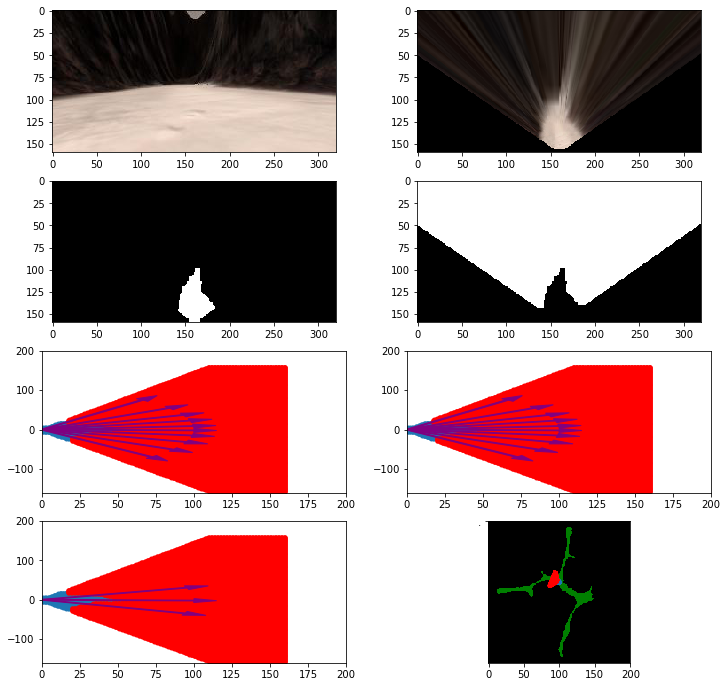

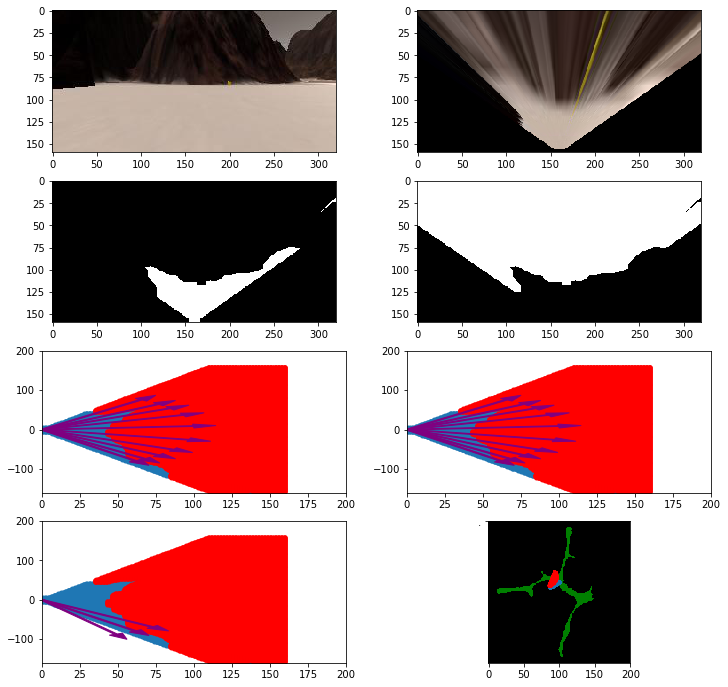

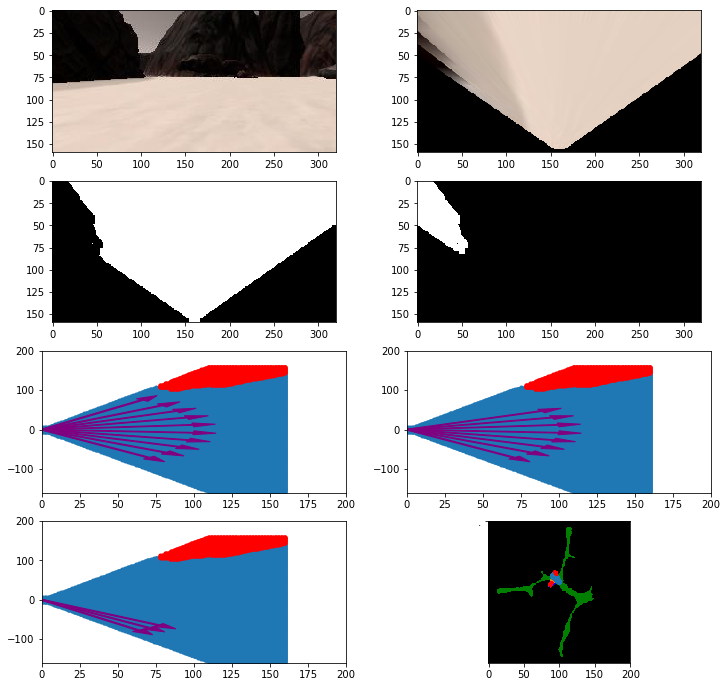

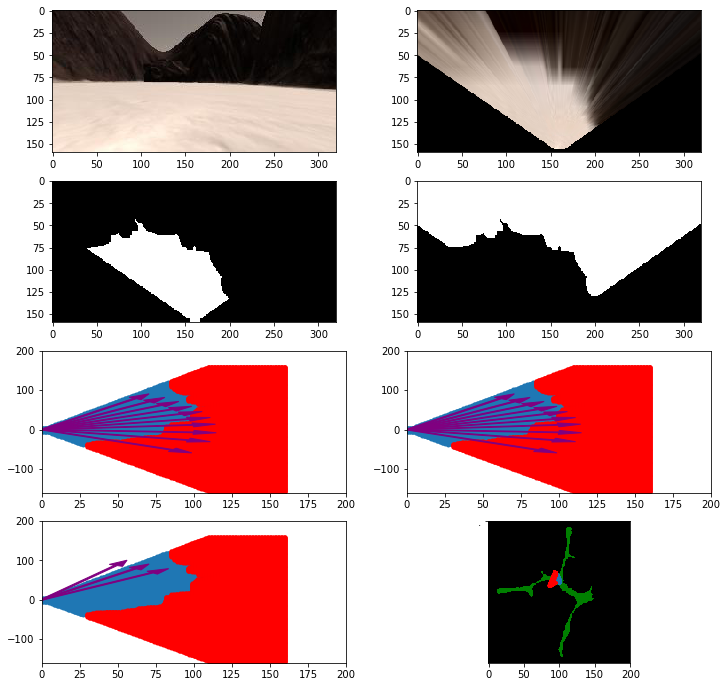

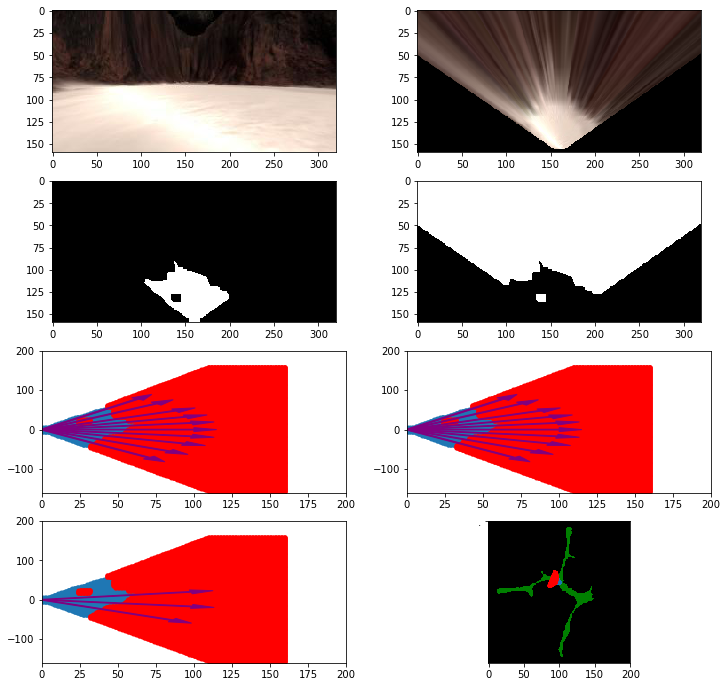

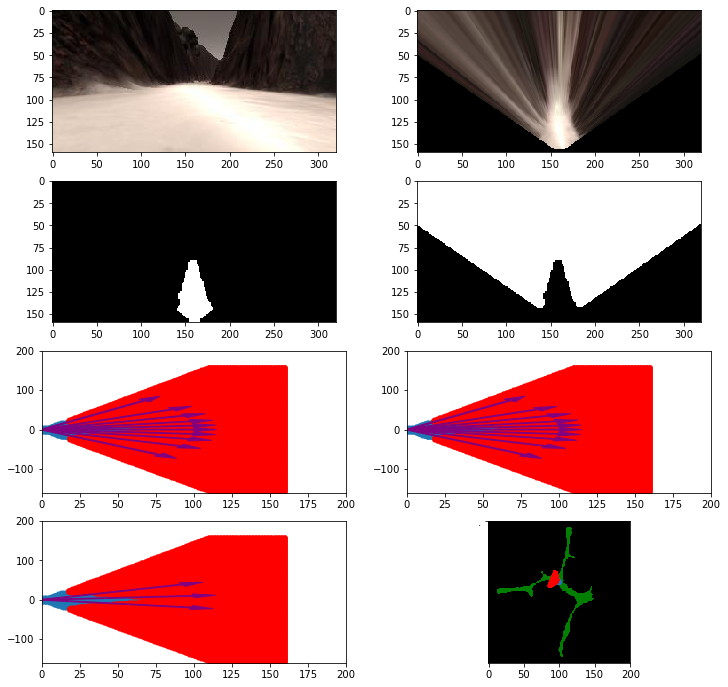

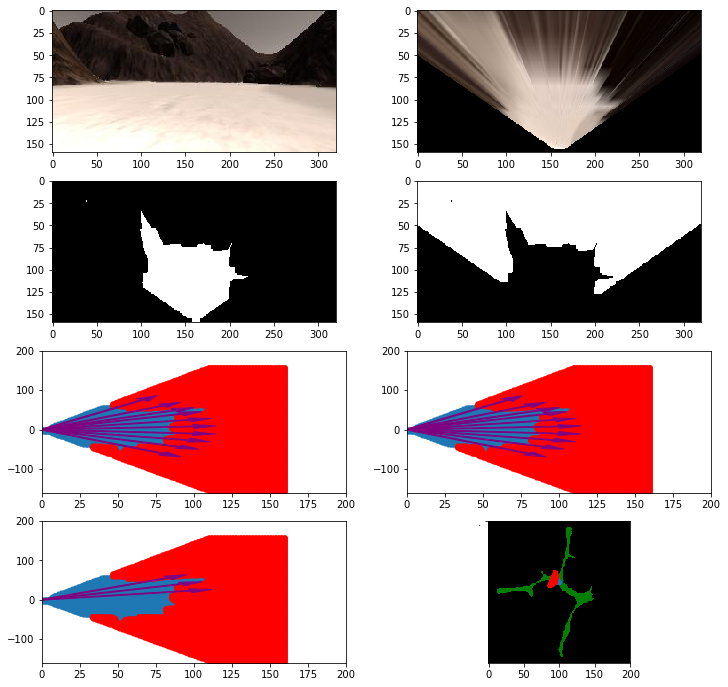

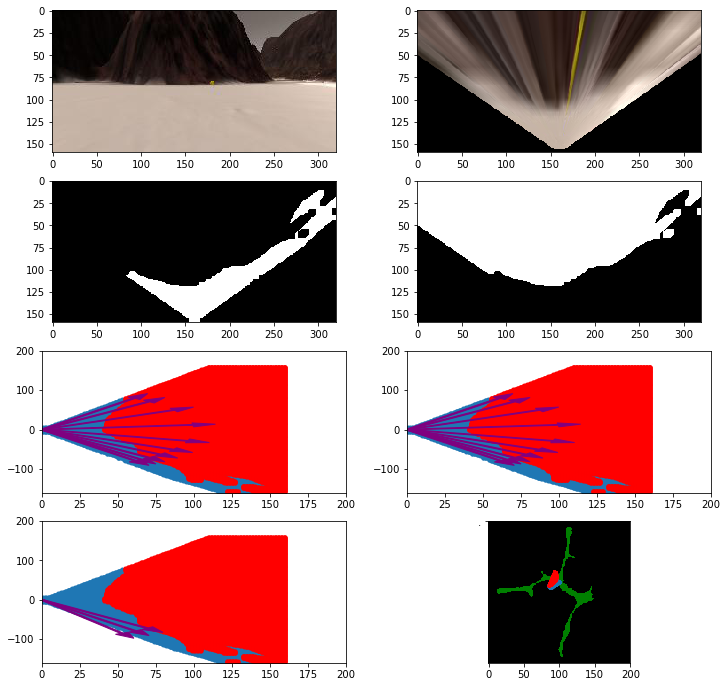

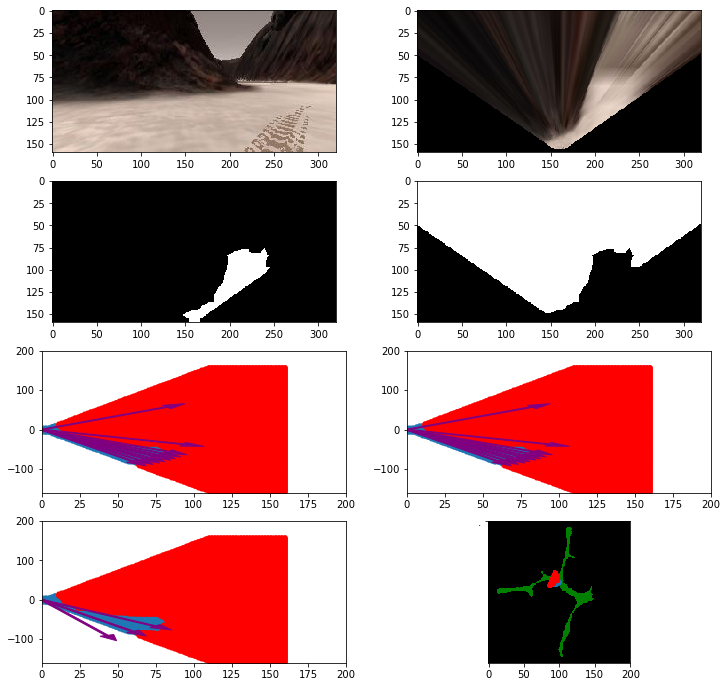

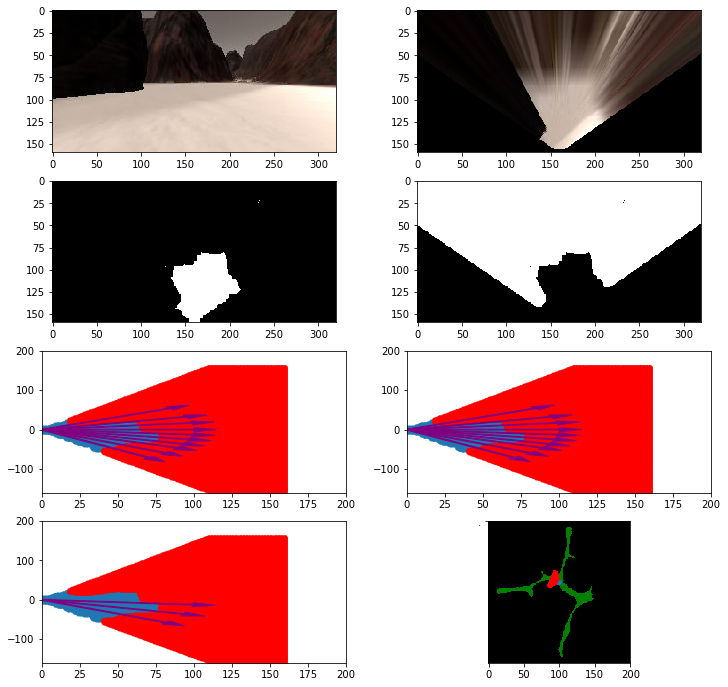

In [47]:
#idx = np.random.randint(0, len(img_list)-1)
for idx in range(initial_time,final_time):
    print(idx)
    perception_step(idx,img_list,df)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


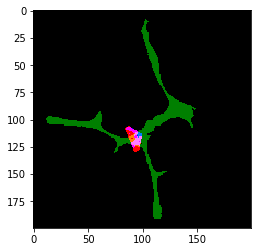

In [48]:
plt.imshow(np.flip(rover_world_map,0),cmap='gray')

4044
all dirc crash

dir list [-0.7699999809265137, -0.6000000238418579, -0.46000000834465027, -0.33000001311302185, -0.1899999976158142, -0.0, 0.14000000059604645, 0.3199999928474426, 0.550000011920929, 0.8299999833106995]
distance for each direction [70.6, 70.6, 25.32, 25.08, 25.0, 25.0, 25.0, 25.0, 27.07, 50.25]
[-0.60000002 -0.76999998  0.82999998]
direction percent matching 0.0
direction percent matching 0.0
direction percent matching 0.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


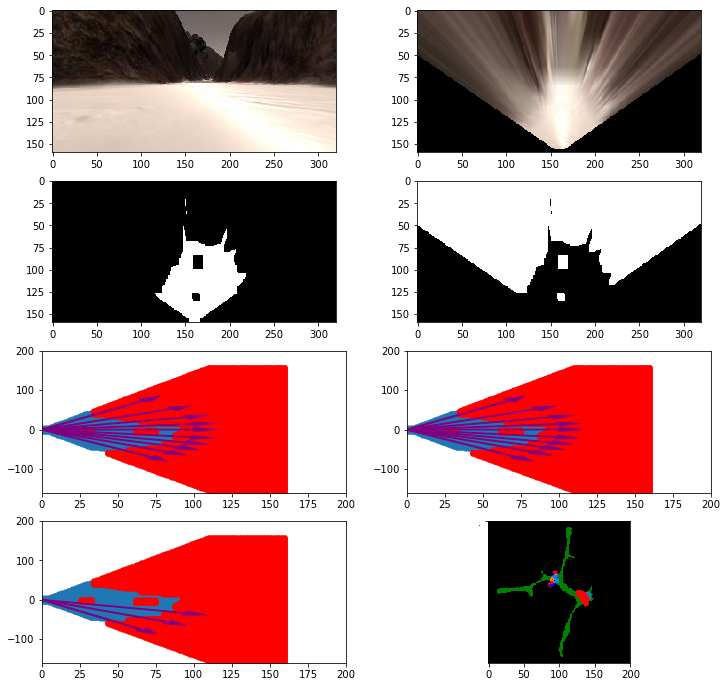

In [50]:
idx = np.random.randint(0, len(img_list)-1)
print(idx)
perception_step(idx,img_list,df)